In [276]:
import utils

import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, \
    TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_similarity_score
from sklearn.utils import class_weight

import keras
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer
from keras.optimizers import RMSprop, Adam, SGD

import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import scipy
import matplotlib.pyplot as plt

from os.path import join, basename, exists
from os import makedirs, listdir

%matplotlib inline

In [358]:
def preproc_target_train(data, reduce_classes=False):    
    diagnoses = data['Код_диагноза'].copy()
    drop_idxs = []
    
    if reduce_classes:
        pop_diagnoses = set(utils.get_most_popular_diagnoses(diagnoses, percent=.85))
        most_pop_diagnose = scipy.stats.mode(diagnoses)[0][0]
    else:
        pop_diagnoses = set(diagnoses)
        most_pop_diagnose = scipy.stats.mode(diagnoses)[0][0]
    
#     diagnoses = diagnoses.apply(
#         lambda diag: diag if diag in pop_diagnoses else most_pop_diagnose
#     )
    for i, diag in enumerate(diagnoses):
        if diag not in pop_diagnoses:
            drop_idxs.append(i)
    data = data.drop(data.index[drop_idxs])
    diagnoses = diagnoses.drop(diagnoses.index[drop_idxs])
    
    return data, diagnoses, pop_diagnoses, most_pop_diagnose

def preproc_target_test(data, pop_diagnoses, most_pop_diagnose):
    diagnoses = data['Код_диагноза'].copy()
    drop_idxs = []
    
#     diagnoses = diagnoses.apply(
#         lambda diag: diag if diag in pop_diagnoses else most_pop_diagnose
#     )

    for i, diag in enumerate(diagnoses):
        if diag not in pop_diagnoses:
            drop_idxs.append(i)
    data = data.drop(data.index[drop_idxs])
    diagnoses = diagnoses.drop(diagnoses.index[drop_idxs])
    
    return data, diagnoses, pop_diagnoses, most_pop_diagnose

In [359]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

class DoctorsPopularityTransformator(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        doctors = x.fillna('sss')
        doctors_voc, counts = np.unique(doctors, return_counts=True)
        self.pop_doctor = doctors_voc[np.argsort(counts)[::-1][0]]
        
        return self

    def transform(self, x):
        x = x.fillna('sss')
        x[x == 'sss'] = self.pop_doctor
        
        return x
    
class GenderTransformator(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        x = x.copy()
        x[x == 1] = 0
        x[x == 2] = 1
        
        return np.expand_dims(x, axis=1)
    
class AgeTransformator(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        return np.expand_dims(x, axis=1)
    
class TopicsTransformator(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        return x

class ClinicTransformator(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        clinics, counts = np.unique(x, return_counts=True)
        self.clinics_to_idx = dict(zip(clinics, range(len(clinics))))
        
        self.most_pop_clinic_idx = np.argmax(counts)
        
        return self
    
    def transform(self, x):
        x_vec = np.zeros((x.shape[0], len(self.clinics_to_idx)), dtype=np.float32)
        for i, clinic in enumerate(x):
            if clinic in self.clinics_to_idx:
                x_vec[i, self.clinics_to_idx[clinic]] = 1.
            else:
                x_vec[i, self.most_pop_clinic_idx] = 1.
        
        return x_vec
    
class RepeatsTransformator(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        return np.expand_dims(x, axis=1)
    
class PatientHistoryTransformator(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=30):
        self.n_features = n_features
    
    def fit(self, x, y=None):
        diagnoses_concat = x.groupby('Id_Пациента').apply(
            lambda group: ' '.join(group['Код_диагноза'].values)
        )

        vectorizer = HashingVectorizer(n_features=self.n_features)
        diagnoses_hashed = vectorizer.fit_transform(diagnoses_concat)
        
        self.history = pd.DataFrame(data={
            'Id_Пациента': diagnoses_concat.index
        })

        self.features = ['history_{}'.format(i) for i in range(self.n_features)]
        self.history[self.features] = pd.DataFrame(diagnoses_hashed.toarray())
        
        return self
    
    def transform(self, x):
        merged = pd.merge(x, self.history, how='left')
        x_history = merged[self.features].fillna(0.0)
        
        return x_history
    
class AmbTransformator(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        return np.expand_dims(x, axis=1)

In [360]:
class NNModel(BaseEstimator, TransformerMixin):
    def __init__(self, batch_size, epochs, tb_log_dir, model_path, validation_data):
        self.batch_size = batch_size
        self.epochs = epochs
        self.tb_log_dir = tb_log_dir
        self.model_path = model_path
        self.validation_data = validation_data
    
    def fit(self, x, y=None):
        self.classes = np.unique(y)
        self.classes_voc = dict(zip(self.classes, range(self.classes.shape[0])))
        self.voc_classes = dict(zip(range(self.classes.shape[0]), self.classes))
        
        y_train_proc = np.zeros((y.shape[0], self.classes.shape[0]), dtype=np.float32)
        for i, yc in enumerate(y):
            y_train_proc[i, self.classes_voc[yc]] = 1.
        
        if self.validation_data is not None:
            valid_y = self.validation_data[1]
            y_valid_proc = np.zeros((valid_y.shape[0], self.classes.shape[0]), dtype=np.float32)
            for i, yc in enumerate(valid_y):
                y_valid_proc[i, self.classes_voc[yc]] = 1.
        
        self.model = Sequential([
            InputLayer(input_shape=(x.shape[1],)),
            Dense(4096, activation='sigmoid'),
            Dense(2048, activation='sigmoid'),
#             Dense(4096, activation='sigmoid'),
#             Dense(4096, activation='sigmoid'),
            Dense(self.classes.shape[0], activation='softmax')
        ])
        
        optim = RMSprop(lr=1e-4, decay=1e-6)
        self.model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
        
        if self.validation_data is not None:
            valid_data = (self.validation_data[0], y_valid_proc)
        else:
            valid_data = None
            
        class_weights = class_weight.compute_class_weight('balanced', self.classes, y)
        
        self.model.fit(x, y_train_proc,
                  batch_size=self.batch_size, epochs=self.epochs,
                  callbacks=[
                      TensorBoard(log_dir=self.tb_log_dir, batch_size=self.batch_size),
                      ModelCheckpoint(filepath=self.model_path, monitor='acc', period=5)
                  ],
                  validation_data=valid_data, class_weight=class_weights)
        
        return self
        
    def transform(self, x):
        pred = self.model.predict(x)
        max_idxs = np.argmax(pred, axis=1)
        
        return np.array(list(map(lambda max_idx: self.voc_classes[max_idx], max_idxs)))

In [361]:
def create_pipeline(train, experiment_dir, model_fname_prefix, reduce_classes=False,
                    no_validation=False, validation_split=0.3):
    train, valid = train_test_split(train, test_size=validation_split)
    train, train_y, pop_diagnoses, most_pop_diagnose = preproc_target_train(train, reduce_classes=reduce_classes)
    print(np.unique(train_y).shape)
    valid, valid_y, _, _ = preproc_target_test(valid, pop_diagnoses, most_pop_diagnose)
    
    model_name = model_fname_prefix + str(utils.get_next_model_id(experiment_dir))
    tb_log_dir = join(experiment_dir, 'log', model_name)
    models_dir = join(experiment_dir, 'models')

    if no_validation:
        model_path = utils.get_model_fname_pattern(models_dir, model_name, no_validation=True)
        validation_split = 0.0
    else:
        model_path = utils.get_model_fname_pattern(models_dir, model_name, no_validation=False)

    pipe_data = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('complaints_pipe', Pipeline([
                    ('complaint_selector', ItemSelector(key='Жалобы (unigramm)')),
                    ('tfidf', TfidfVectorizer(ngram_range=(1,1), min_df=3, use_idf=False,
                                              stop_words=stopwords.words('russian'), max_features=500))
                ])),
                ('complaints_n_pipe', Pipeline([
                    ('complaint_n_selector', ItemSelector(key='Жалобы (ngramm)')),
                    ('tfidf', TfidfVectorizer(ngram_range=(1,1), min_df=1, use_idf=False,
                                              stop_words=stopwords.words('russian'), max_features=500))
                ])),
                ('doctor_pipe', Pipeline([
                    ('doctor_selector', ItemSelector(key='Врач')),
                    ('doc_pop', DoctorsPopularityTransformator()),
                    ('count_vect', CountVectorizer())
                ])),
                ('gender_pipe', Pipeline([
                    ('gender_selector', ItemSelector(key='Пол')),
                    ('gender_transform', GenderTransformator())
                ])),
                ('age_pipe', Pipeline([
                    ('age_selector', ItemSelector(key='Возраст')),
                    ('age_transformator', AgeTransformator())
                ])),
                ('topics_pipe', Pipeline([
                    ('topic_selector', ItemSelector(key=['topic' + str(i) for i in range(305)])),
                    ('topics_transform', TopicsTransformator())
                ])),
                ('clinic_pipe', Pipeline([
                    ('clinic_selector', ItemSelector(key='Клиника')),
                    ('clinic_transform', ClinicTransformator())
                ])),
                ('repeats_pipe', Pipeline([
                    ('repeats_selector', ItemSelector(key='Повторный приём')),
                    ('repeats_transform', RepeatsTransformator())
                ])),
                ('recomendations_pipe', Pipeline([
                    ('recomendations_selector', ItemSelector(key='Рекомендация')),
                    ('recomendations_vect', CountVectorizer(analyzer=lambda x: [x]))
                ])),
                ('amb_pipe', Pipeline([
                    ('amb_selector', ItemSelector(key='Amb')),
                    ('amb_transform', AmbTransformator())
                ])),
#                 ('history_pipe', PatientHistoryTransformator(n_features=50))
            ]
        ))
    ])
    
    train = pipe_data.fit_transform(train, train_y)
    valid = pipe_data.transform(valid)
    
    if no_validation:
        clf = NNModel(batch_size=128, epochs=200, tb_log_dir=tb_log_dir,
                        model_path=model_path, validation_data=None)
    else:
        clf = NNModel(batch_size=128, epochs=200, tb_log_dir=tb_log_dir,
                        model_path=model_path, validation_data=(valid, valid_y))
    
    return clf, pipe_data, model_name, train, train_y, valid, valid_y, pop_diagnoses, most_pop_diagnose

In [326]:
train = utils.load_data('data/train_data_complaints_repeats_doctors_amb_rec.csv')
train_topics = np.load('data/topics_train_ngramm.npy')
train = utils.join_topics(train, train_topics)
# train, valid = train_test_split(train, test_size=0.3)

In [327]:
clf, pipe_data, model_name, train, train_y, \
    valid, valid_y, pop_diagnoses, most_pop_diagnose = create_pipeline(
    train, 'simple_models2', 'nn_3dense', reduce_classes=True,
    no_validation=False, validation_split=0.3
)

/root/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


(421,)


In [328]:
clf.fit(train, train_y)

Train on 39044 samples, validate on 16701 samples
Epoch 1/200
39044/39044 [==============================] - 5s 135us/step - loss: 5.2137 - acc: 0.0583 - val_loss: 5.3090 - val_acc: 0.0338
Epoch 2/200
31104/39044 [======================>.......] - ETA: 0s - loss: 4.9580 - acc: 0.1037

KeyboardInterrupt: 

In [283]:
pred = clf.transform(valid)

In [285]:
matches = []
valid_y_unique, valid_y_counts = np.unique(valid_y, return_counts=True)
pred_unique, pred_counts = np.unique(pred, return_counts=True)
for valid_cl in valid_y_unique:
    if valid_cl in pred_unique:
        valid_idx = np.where(valid_y_unique == valid_cl)[0]
        pred_idx = np.where(pred_unique == valid_cl)[0]
        matches.append((valid_cl, valid_y_counts[valid_idx], pred_counts[pred_idx]))

In [286]:
valid_dist = list(list(zip(*matches))[1])
valid_dist += [valid_y_counts[i] for i, v in enumerate(valid_y_unique) if v not in valid_dist]
pred_dist = list(list(zip(*matches))[2])

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


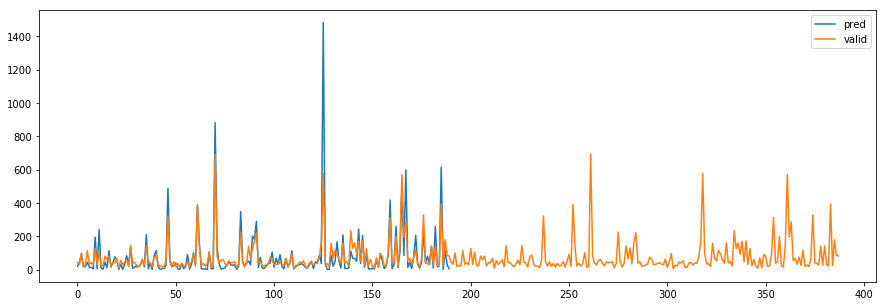

In [287]:
plt.figure(figsize=(15, 5))

plt.plot(pred_dist, label='pred')
plt.plot(valid_dist, label='valid')
plt.legend()

## Submit

In [373]:
train = utils.load_data('data/train_data_complaints_repeats_doctors_amb_rec.csv')
train_topics = np.load('data/topics_train_ngramm.npy')
train = utils.join_topics(train, train_topics)
# train_y, pop_diagnoses, most_pop_diagnose = preproc_target_train(train, reduce_classes=False)

In [374]:
clf, pipe_data, model_name, train, train_y, \
    valid, valid_y, pop_diagnoses, most_pop_diagnose = create_pipeline(
    train, 'simple_models2', 'nn_3dense', reduce_classes=True,
    no_validation=True, validation_split=0.3
)

/root/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


(280,)


In [375]:
clf.fit(train, train_y)

Epoch 1/200
36866/36866 [==============================] - 4s 112us/step - loss: 4.9874 - acc: 0.0613
Epoch 2/200
36866/36866 [==============================] - 4s 106us/step - loss: 4.6672 - acc: 0.1241
Epoch 3/200
36866/36866 [==============================] - 4s 104us/step - loss: 4.1817 - acc: 0.1980
Epoch 4/200
36866/36866 [==============================] - 4s 106us/step - loss: 3.6997 - acc: 0.2475
Epoch 5/200
36866/36866 [==============================] - 4s 105us/step - loss: 3.3189 - acc: 0.2757
Epoch 6/200
36866/36866 [==============================] - 4s 103us/step - loss: 3.0433 - acc: 0.2909
Epoch 7/200
36866/36866 [==============================] - 4s 106us/step - loss: 2.8503 - acc: 0.3022
Epoch 8/200
36866/36866 [==============================] - 4s 108us/step - loss: 2.7079 - acc: 0.3142
Epoch 9/200
36866/36866 [==============================] - 4s 106us/step - loss: 2.6029 - acc: 0.3248
Epoch 10/200
36866/36866 [==============================] - 4s 106us/step - loss: 

36866/36866 [==============================] - 4s 111us/step - loss: 1.7558 - acc: 0.4633
Epoch 81/200
36866/36866 [==============================] - 4s 106us/step - loss: 1.7517 - acc: 0.4647
Epoch 82/200
36866/36866 [==============================] - 4s 112us/step - loss: 1.7488 - acc: 0.4665
Epoch 83/200
36866/36866 [==============================] - 4s 108us/step - loss: 1.7448 - acc: 0.4676
Epoch 84/200
36866/36866 [==============================] - 4s 108us/step - loss: 1.7425 - acc: 0.4675
Epoch 85/200
36866/36866 [==============================] - 4s 106us/step - loss: 1.7384 - acc: 0.4682
Epoch 86/200
36866/36866 [==============================] - 4s 107us/step - loss: 1.7361 - acc: 0.4686
Epoch 87/200
36866/36866 [==============================] - 4s 107us/step - loss: 1.7334 - acc: 0.4693
Epoch 88/200
36866/36866 [==============================] - 4s 110us/step - loss: 1.7278 - acc: 0.4737
Epoch 89/200
36866/36866 [==============================] - 4s 110us/step - loss: 1.72

KeyboardInterrupt: 

In [376]:
test = utils.load_data('data/test_data_complaints_repeats_doctors_amb_rec.csv')
test_topics = np.load('data/topics_test_ngramm.npy')
test = utils.join_topics(test, test_topics)

In [377]:
test_proc = pipe_data.transform(test)
test_pred = clf.transform(test_proc)

In [378]:
submit = pd.DataFrame({'Id_Записи': test['Id_Записи'], 'Код_диагноза': test_pred})

In [379]:
submit['Код_диагноза'].value_counts()

M42.1     1985
J06.9     1759
N76.0     1378
N77.1*     851
N41.1      834
Z00.0      788
Z01.4      783
Z32.1      723
I11        641
K30        601
M51.8      575
Z34.0      535
J00        532
M54.8      448
M65        440
Z01.8      435
J35.0      425
K29.9      414
N60.1      413
G90        367
D23.9      352
K29.5      321
H52.1      298
M54.2      297
J01.0      283
B37.3+     283
L30.8      269
M53.8      246
I83.9      246
H61.2      235
          ... 
I87.0        6
Z34          6
J18.0        6
M50.1        6
M42.0        6
E04.1        6
M76.0        5
E55          5
G24.9        4
J02.9        4
J20          4
H10.3        4
J03.9        3
Z35          3
E28.8        3
L50.9        3
J01          2
J01.8        2
L28.0        2
G43.0        2
E22.1        2
E05.9        1
L23.9        1
O04          1
A63.8        1
M51.2        1
R73          1
N10          1
R52.0        1
B37          1
Name: Код_диагноза, Length: 266, dtype: int64

In [380]:
old_submit = pd.read_csv('data/submission_last_diag.csv')

In [381]:
new_submit = submit.copy()

for idx, code in list(zip(old_submit['Id_Записи'], old_submit['Код_диагноза'])):
#     print(idx, code)
    if code != '-':
        new_submit.loc[idx, 'Код_диагноза'] = code

In [382]:
new_submit.to_csv('submit/bow_simple2_nn66_3dense_diag_pop_and_drop280_compl_uni-n_gram_doctor_new_topics_clinic_repeats_recs_amb_class_weights_merged.csv', header=True, index=False)